In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report

In [2]:
df = pd.read_parquet("df.parquet")

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,orig_balance_change,dest_balance_change,amount_to_orig_balance_ratio,is_zero_balance_after,high_value_transfer,dest_account_type,same_balance_before,same_balance_after
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,9839.64,0.0,0.057834,0,0,M,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1864.28,0.0,0.087731,0,0,M,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,181.00,0.0,0.994505,1,0,C,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,181.00,21182.0,0.994505,1,0,C,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,11668.14,0.0,0.280788,0,0,M,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 20 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   step                          int64  
 1   type                          object 
 2   amount                        float64
 3   nameOrig                      object 
 4   oldbalanceOrg                 float64
 5   newbalanceOrig                float64
 6   nameDest                      object 
 7   oldbalanceDest                float64
 8   newbalanceDest                float64
 9   isFraud                       int64  
 10  isFlaggedFraud                int64  
 11  hour                          int64  
 12  orig_balance_change           float64
 13  dest_balance_change           float64
 14  amount_to_orig_balance_ratio  float64
 15  is_zero_balance_after         int64  
 16  high_value_transfer           int64  
 17  dest_account_type             object 
 18  same_balance_before   

In [5]:
numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'hour', 'orig_balance_change', 
                      'dest_balance_change', 'amount_to_orig_balance_ratio']
categorical_features = ['type', 'is_zero_balance_after', 'high_value_transfer', 'dest_account_type', 'same_balance_before', 'same_balance_after']

features = numerical_features + categorical_features

In [6]:
X = df[features]
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [7]:
def train_predict_catboost(X_train, y_train, X_test, categorical_features):
    # Initialize the CatBoostClassifier
    catboost_model = CatBoostClassifier(random_seed=42, silent=True)
    
    # Train the model
    catboost_model.fit(X_train, y_train, cat_features=categorical_features)
    
    # Predict probabilities
    y_pred_proba = catboost_model.predict_proba(X_test)
    
    # Convert probabilities to predicted class
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    return y_pred, y_pred_proba, catboost_model

In [8]:
def compute_metrics(y_test, y_pred):
    # Accuracy
    acc_cat = accuracy_score(y_test, y_pred)
    print(f"Accuracy = {acc_cat}")
    
    # Balanced Accuracy
    bal_acc_cat = balanced_accuracy_score(y_test, y_pred)  
    print(f"Balanced Accuracy = {bal_acc_cat}")
    
    # F1 Score
    f1_cat = f1_score(y_test, y_pred, average='weighted')
    print(f"F1 Score = {f1_cat}")
    
    # MCC (Matthews Correlation Coefficient)
    mcc_cat = matthews_corrcoef(y_test, y_pred)
    print(f"MCC = {mcc_cat}")

def plot_confusion_matrices(y_test, y_pred):
    # Confusion Matrices (raw counts) ensuring all classes are represented
    cm_cat = confusion_matrix(y_test, y_pred)

    # Normalize Confusion Matrices (row-wise)
    cm_cat_norm = cm_cat.astype('float') / cm_cat.sum(axis=1, keepdims=True)

    # Create side-by-side subplots for raw confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))   

    # CatBoost Confusion Matrix (Raw)
    sns.heatmap(cm_cat, annot=True, fmt="d", cmap="coolwarm", ax=ax1)
    ax1.set_title('Confusion Matrix for CatBoost (Raw)')
    ax1.set_ylabel('True Labels')
    ax1.set_xlabel('Predicted Labels')

    # CatBoost Confusion Matrix (Normalized)
    sns.heatmap(cm_cat_norm, annot=True, cmap="coolwarm", fmt='.4f', ax=ax2)
    ax2.set_title('Confusion Matrix for CatBoost (Normalized)')
    ax2.set_ylabel('True Labels')
    ax2.set_xlabel('Predicted Labels')
    
    
    plt.tight_layout()
    plt.show()

In [9]:
y_pred_cat, y_pred_proba_cat, catboost_model = train_predict_catboost(X_train, y_train, X_test, categorical_features)

In [10]:
with open("catboost_model.pkl", "wb") as file:
    pickle.dump(catboost_model, file)

In [11]:
compute_metrics(y_test, y_pred_cat)

Accuracy = 0.9998031471312132
Balanced Accuracy = 0.9581252776339575
F1 Score = 0.9998023676905445
MCC = 0.9235353184492706


In [12]:
print(classification_report(y_test, y_pred_cat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083486
           1       0.93      0.92      0.92      6610

    accuracy                           1.00   5090096
   macro avg       0.97      0.96      0.96   5090096
weighted avg       1.00      1.00      1.00   5090096



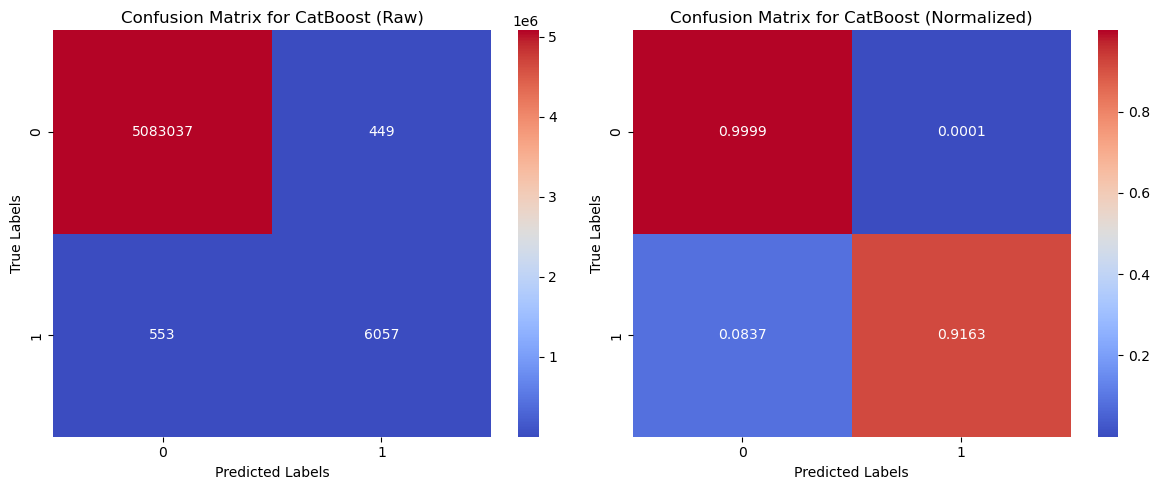

In [13]:
plot_confusion_matrices(y_test, y_pred_cat)

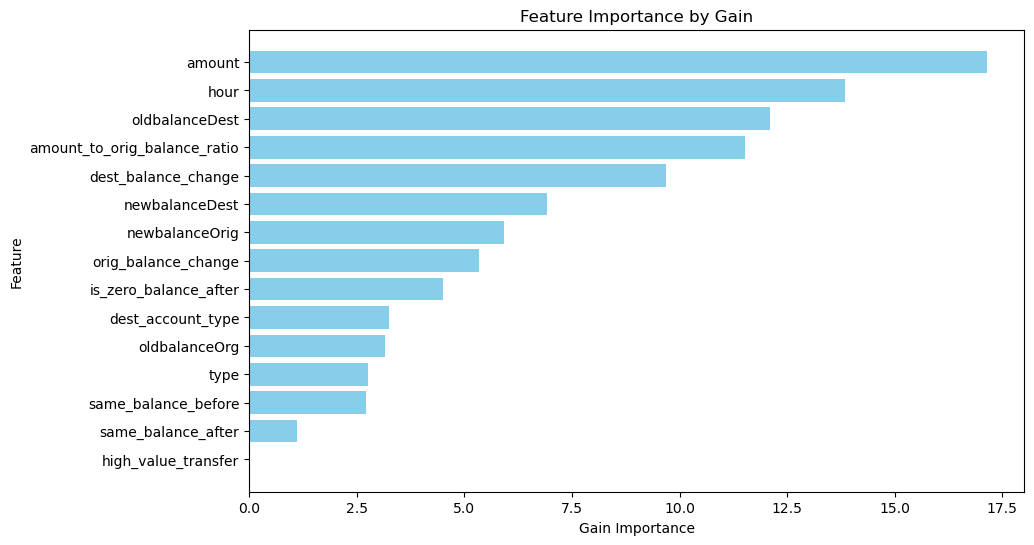

In [14]:
feature_importances = catboost_model.get_feature_importance(type="FeatureImportance")
# Plot the feature importances
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort by importance for better visualization
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Gain Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by Gain')
plt.gca().invert_yaxis()
plt.show()